In [1]:
# Nhập thư viện 
import pandas as pd
import math
import numpy as np
import graphviz
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('./data.csv')

In [3]:
print(dataset)

   department    age   salary  count  status
0       sales  31-35  46K-50K     30  senior
1       sales  26-30  26K-30K     40  junior
2       sales  31-35  31K-35K     40  junior
3     systems  21-25  46K-50K     20  junior
4     systems  31-35  66K-70K      5  senior
5     systems  26-30  46K-50K      3  junior
6     systems  41-45  66K-70K      3  senior
7   marketing  36-40  46K-50K     10  senior
8   marketing  31-35  41K-45K      4  junior
9   secretary  46-50  36K-40K      4  senior
10  secretary  26-30  26K-30K      6  junior


In [4]:
dataset.describe()

,count
count,11.000000
mean,15.000000
std,14.953261
min,3.000000
25%,4.000000
50%,6.000000
75%,25.000000
max,40.000000


In [5]:
def gini(probs):
    impurity = 1
    for prob in probs:
        impurity -= prob ** 2
    return impurity

def gini_index(data, split_attribute_name, target_name):
    total_gini = gini(data[target_name].value_counts(normalize=True))
    weighted_gini = 0
    for subset_name, subset in data.groupby(split_attribute_name):
        subset_gini = gini(subset[target_name].value_counts(normalize=True))
        weighted_gini += (len(subset) / len(data)) * subset_gini
    gini_index = weighted_gini
    return gini_index

gini_age = gini_index(dataset, 'department', 'status')
gini_age = gini_index(dataset, 'age', 'status')
gini_salary = gini_index(dataset, 'salary', 'status')
gini_count = gini_index(dataset, 'count', 'status')

print('Gini index(department) =', gini_age)
print('Gini index(age) =', gini_age)
print('Gini index(salary) =', gini_salary)
print('Gini index(count) =', gini_count)

Gini index(department) = 0.18181818181818182
Gini index(age) = 0.18181818181818182
Gini index(salary) = 0.18181818181818182
Gini index(count) = 0.18181818181818182


<img src="./img/gain.png" width="400"/>

In [6]:
# entropy:
def entropy(probs):
    entropy = 0
    for prob in probs:
        if prob != 0:
            entropy += prob * math.log2(prob)
    return -entropy

In [7]:
# information gained
def information_gain(data, split_attribute_name, target_name):
    total_entropy = entropy(data[target_name].value_counts(normalize=True))
    weighted_entropy = 0
    for subset_name, subset in data.groupby(split_attribute_name):
        subset_entropy = entropy(subset[target_name].value_counts(normalize=True))
        
        # information needed:
        weighted_entropy += (len(subset) / len(data)) * subset_entropy
    
    information_gain = total_entropy - weighted_entropy
    return information_gain

In [8]:
# gọi hàm và in 
iga = information_gain(dataset, 'department', 'status')
igi = information_gain(dataset, 'age', 'status')
igs = information_gain(dataset, 'salary', 'status')
igc = information_gain(dataset, 'count', 'status')
print('Gain(department) =', iga)
print('Gain(age) =', igi)
print('Gain(salary) =', igs)
print('Gain(count) =', igc)

Gain(department) = 0.016313165825732057
Gain(age) = 0.6303938478405928
Gain(salary) = 0.6303938478405928
Gain(count) = 0.6303938478405928


# Phân chia dữ liệu

<img src="./img/split_infor.png" width="400"/>

In [9]:
def split_information(data, split_attribute_name):
    num_entries = len(data)
    value_counts = data[split_attribute_name].value_counts()
    probs = value_counts / num_entries
    split_infor = -(probs * np.log2(probs)).sum()
    return split_infor

<img src="./img/gain_ratio.png" width="400"/>

In [10]:
# Gain ratio
def gain_ratio(dataset, split_attribute_name, target_name):
    split_info = split_information(dataset, split_attribute_name)
    gain = information_gain(dataset, split_attribute_name, target_name)
    if split_info == 0:
        return 0
    
    return gain / split_info

In [11]:
gain_ratio_age = gain_ratio(dataset, 'department', 'status')
gain_ratio_age = gain_ratio(dataset, 'age', 'status')
gain_ratio_salary = gain_ratio(dataset, 'salary', 'status')
gain_ratio_count = gain_ratio(dataset, 'count', 'status')
print('gain_ratio(department) =', gain_ratio_age)
print('gain_ratio(age) =', gain_ratio_age)
print('gain_ratio(salary) =', gain_ratio_salary)
print('gain_ratio(count) =', gain_ratio_count)

gain_ratio(department) = 0.27409662898791615
gain_ratio(age) = 0.27409662898791615
gain_ratio(salary) = 0.26615488789344205
gain_ratio(count) = 0.21633452563580183


In [12]:
# Tạo cấu trúc cây quyết định theo thuật toán ID3 
def id3(data, original_data, features, target_attribute_name, parent_node_class=None):

    # Nếu tất cả các giá trị đều giống nhau, thì trả về một giá trị
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]

    # Nếu tệp dữ liễu trống, thì trả về chế độ mặc định của tập dữ liệu gốc
    elif len(data) == 0:
        return np.unique(original_data[target_attribute_name])[np.argmax(original_data[target_attribute_name].value_counts())]
    
    #
    elif len(features) == 0:
        return parent_node_class

    else:
        # đặt giá trị mặc định cho node của tập con hợp con hiện tại
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(data[target_attribute_name].value_counts())]

        # Chọn đặc trưng phân chia dữ liệu tốt nhất 
        item_values = [information_gain(data, feature, target_attribute_name) for feature in features] # Return the information gain values for the features in the dataset
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]

        # Tạo cấu trúc cây, gốc cây là tên của đặc trưng 
        tree = {best_feature: {}}

        # Xóa những đặc trưng đã được thêm vào 
        features = [i for i in features if i != best_feature]

        # Thêm nhánh cho đặc trưng gốc 
        for value in np.unique(data[best_feature]):
            value = value

            # Phân chia tập dữ liệu theo đối tượng có thông tin lớn nhất và tạo tập dữ liệu con
            sub_data = data.where(data[best_feature] == value).dropna()

            # gọi thuật toán ID3 cho mội tập dữ liệu con 
            subtree = id3(sub_data, dataset, features, target_attribute_name, parent_node_class)

            # thêm nhánh phụ, phát triển các nhánh phụ 
            tree[best_feature][value] = subtree

        return tree


In [13]:
target_attribute_name = 'status'
features = dataset.columns.tolist()[:-1]
id3_tree = id3(dataset, dataset, features, target_attribute_name)

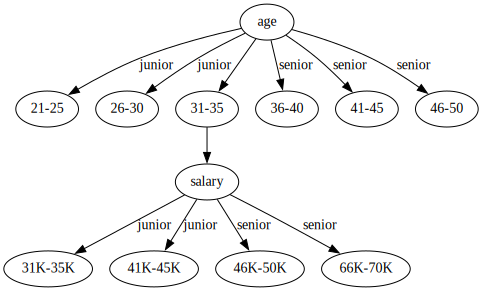

In [14]:
#Vẽ cây

def visualize_tree(tree):
    dot = graphviz.Digraph()

    def add_nodes(tree, parent=None):
        for node_name, subtree in tree.items():
            if isinstance(subtree, dict):
                if parent is not None:
                    dot.edge(str(parent), str(node_name))
                add_nodes(subtree, parent=node_name)
            else:
                dot.edge(str(parent), str(node_name), label=str(subtree))

    add_nodes(tree)
    return dot

visualize_tree(id3_tree)
